<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/01-Pandas/A3-Advanced_Data_Manipulation_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pandas beyond SQL: Advanced Data Manipulation Techniques

Install the necessary libraries to connect to MySQL and to read Excel files

In [3]:
# @title Setup and preliminaries

!pip3 install -U -q PyMySQL sqlalchemy

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Render our plots with high resolution
%config InlineBackend.figure_format = 'retina'

# Make the graphs a bit bigger
matplotlib.style.use(["seaborn-v0_8-talk", "seaborn-v0_8-ticks", "seaborn-v0_8-whitegrid"])

# Setting the default figure size for Pandas plots
pd.options.plotting.backend = 'matplotlib'
plt.rcParams['figure.figsize'] = [10, 3]

In [4]:
# @title MySQL Setup

import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2015',
    db = 'doh_restaurants',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

# This query returns back the restaurants in the DOH database
sql = '''
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO,
          R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, R.NTA
		FROM doh_restaurants.restaurants R
'''

with engine.connect() as connection:
	restaurants = pd.read_sql(text(sql), con=connection)

# This query returns back the results of the inspections of each restaurant
sql = '''
	SELECT R.CAMIS, R.DBA, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.NTA,
				 I.INSPECTION_DATE, I.INSPECTION_ID,
				 I.INSPECTION_TYPE, I.SCORE, I.GRADE
	FROM restaurants R
		JOIN inspections I ON I.CAMIS = R.CAMIS
'''

with engine.connect() as connection:
	inspections = pd.read_sql(text(sql), con=connection)

# Pivot Tables



## Simple pivot tables

[Pivot tables](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) is one of the most commonly used exploratory tools, and in Pandas they are extremely flexible.

In their simplest form, they can generate the same results as aggregate queries.

In [17]:
rest_per_boro = pd.pivot_table(
    data=restaurants,
    aggfunc="count",  # we count... (the aggregation function)
    values="CAMIS",  # ...the different CAMIS numbers (what we aggregate)
    index="BORO",  # ..per BORO (and how we specify the groups, ie the variable that we use for dividing the data)
)


In [18]:
# The full pivot table
rest_per_boro

,CAMIS
BORO,
Bronx,1818
Brooklyn,5156
Manhattan,7579
Queens,4438
Staten Island,751


Or, let's try to examine the average inspection score, broken down by cuisine.

In [19]:
score_per_cuisine = pd.pivot_table(
    data=inspections,
    index="CUISINE_DESCRIPTION",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # we calculate the average/mean score
)

In [20]:
# The full pivot table
score_per_cuisine

,SCORE
CUISINE_DESCRIPTION,
Afghan,14.440000
African,26.276119
American,14.864405
Asian/Asian Fusion,19.804598
Australian,15.927273
...,...
Tex-Mex,13.247268
Thai,19.934236
Turkish,19.000000


<Axes: ylabel='CUISINE_DESCRIPTION'>

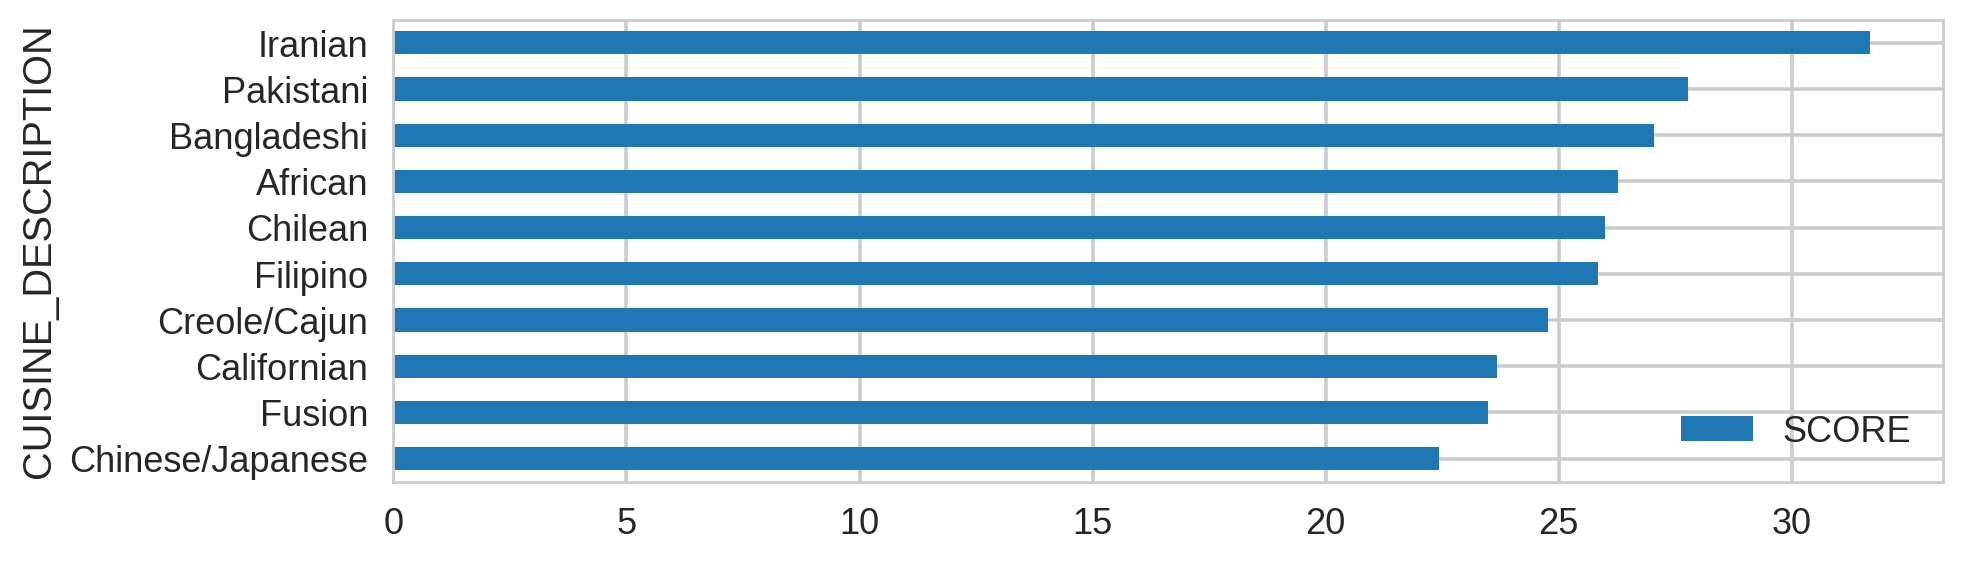

In [12]:
# Plotting the scores of the 10 highest scoring cuisines
(
    score_per_cuisine
    .sort_values('SCORE') # sort in asceding order of score
    .tail(10) # take the 10 entries in the largest values (at the botoom)
    .plot(kind='barh') # create a bar plot
)

### Exercise

Show the average inspection score broken down by neighborhood code (the `NTA` variable).

### Pivot Tables and Dates

In [21]:
# Count the number of CAMIS values that appear on each date
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

In [22]:
pivot

,CAMIS
INSPECTION_DATE,
2015-10-14,1
2015-11-19,1
2015-11-20,1
2015-12-01,1
2015-12-12,1
...,...
2024-05-20,107
2024-05-21,86
2024-05-22,99


Now, let's plot this. By default, Pandas considers the "index" column to be the x-axis, and plots the rest.

<Axes: xlabel='INSPECTION_DATE'>

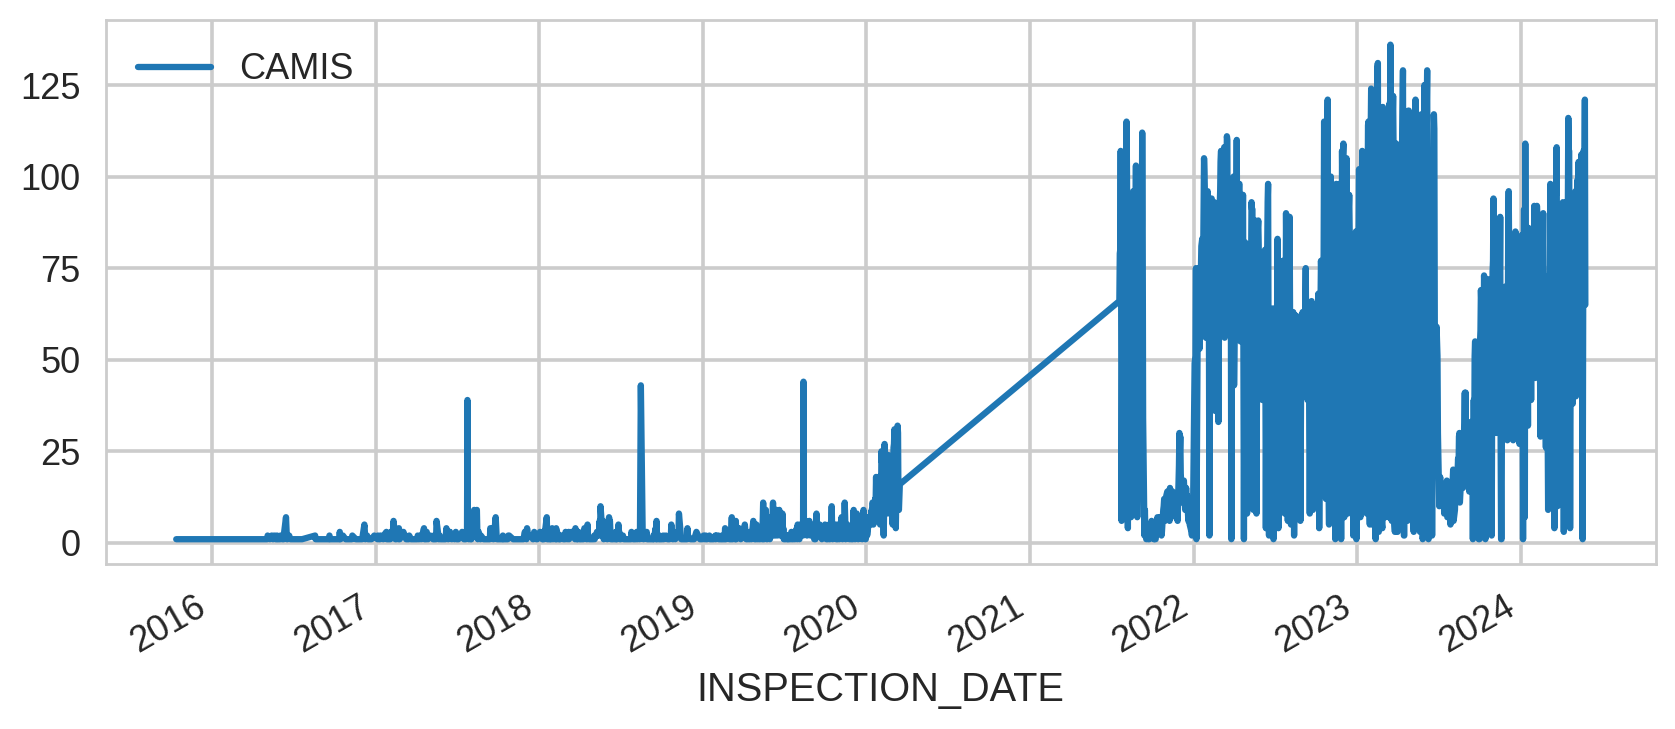

In [24]:
pivot.plot(kind = 'line', y = 'CAMIS', figsize=(10, 4))

<Axes: xlabel='INSPECTION_DATE'>

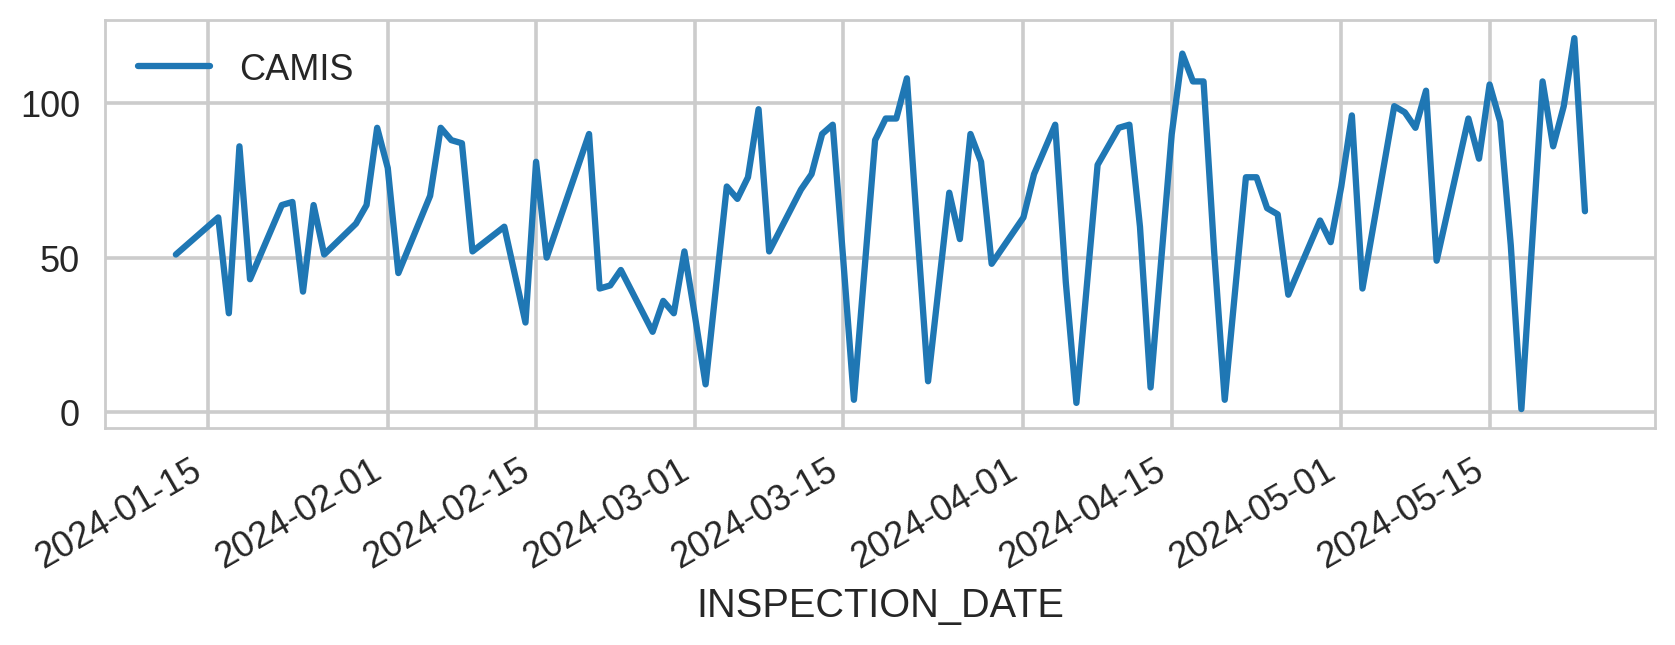

In [25]:
# We keep the last 100 entries and plot
pivot.tail(100).plot()

### Exercise

Now let's do an exercise,  instead of counting the number of inspections, we want to compute the average score assigned by the inspectors. Hint: We will need to change the `values` and the `aggfunc` parameters in the `pivot_table` function above.

In [ ]:
# your code here

#### Solution

In [ ]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # compute the average SCORE
)

In [ ]:
pivot.plot(figsize=(10, 4))

### Changing date granularity

We can also use the [resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) command to change the frequency from one day, to, say, 7 days. Then we can compute, say, the average (`mean()`) for these days, or the total number (`sum()`) of inspections.

In [ ]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

pivot.resample("1W").sum()

Now, let's plot this. By default, Pandas considers the "index" column to be the x-axis, and plots the rest.

In [ ]:
# Plot the average number of inspections, over 7-day periods
pivot.resample("1W").sum().plot()

In [ ]:
# Plot the total number of inspections, over 1-month periods
pivot.resample("1M").sum().plot()

In [ ]:
plot = pivot.resample("7D").mean().plot()
plot.set_xlabel("Date of Inspection")
plot.set_ylabel("Average Number of Inspections (over a 7-day period)")
plot.set_title("Analysis of Number of Inspections over Time")

### Pivot Table with two (or more) variables

We would like to break down the results by borough, so we add the `column` parameter.

In [ ]:
# Show grades broken down by borough
pivot2 = pd.pivot_table(
    data=inspections,  #
    index="GRADE",
    columns="BORO",
    values="CAMIS",
    aggfunc="count"
)
pivot2

In [ ]:
# By default, the "index" becomes the x-axis and we plot all numeric columns
pivot2.plot(kind='bar')

## Normalization, with application to Pivot Tables (and beyond)

In [ ]:
# Let's say that we want to normalize the values
# to account for the different number of inspections
# in each borough
pivot2.sum()

In [ ]:
# This command normalizes each column, by dividing with its sum:
pivot2 / pivot2.sum()

In [ ]:
normalized_by_borough = pivot2 / pivot2.sum()

# Percent of inspections per borough with a given grade
normalized_by_borough.plot(kind='bar')

#### Normalization and Transpose

In [ ]:
# This takes the transpose of the dataframe
pivot2.T

In [ ]:
# Plotting the transpose now uses the boroughs as the "x" axis
pivot2.T.plot(kind='barh')

In [ ]:
# Variation,
pivot2.T.plot(kind='barh', stacked=True)

In [ ]:
normalized_by_borough.T.plot(kind='barh', stacked=True).legend(frameon=True)



### Exercise

We now want to examine if different cuisines have different inspection scores. Compute the average inspection score by cuisine. Use the `sort_values()` command ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html)) to order cuisines by their inspection scores. Analyze further by breaking down the score over inspection dates, and plot.

#### Solution

In [ ]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # dates are the rows
    columns="CUISINE_DESCRIPTION",  # cuisines are the columns
    values="SCORE",  # we analyze the SCORE
    aggfunc="mean",  # compute the average SCORE
)
# Select 3 columns (american, frenchn, chinese), compute the average score for a month
# and plot the results
pivot[["American", "French", "Chinese"]].resample("1M").mean().plot(figsize=(10, 4))

## Advanced Pivot Tables

We can also add multiple attributes in the index and columns. It is also possible to have multiple aggregation functions, and we can even define our own aggregation functions.

In [ ]:
# We break down by BORO and GRADE, and also calculate
# inspections scores
pivot_advanced = pd.pivot_table(
    data=inspections,  #
    index="INSPECTION_DATE",
    columns=["BORO", "GRADE"],
    values="SCORE",
    aggfunc=["mean", "std"],
)

# Take the total number of inspections (unique and non-unique)
agg = pivot_advanced.resample("1M").mean()

# Show the last 5 entries and show the transpose (.T)
agg.tail().T

In [ ]:
# your code here

# Defining new columns -- `assign()` and `apply()`



### Using the `assign()` approach

The `assign` command applies a function to a dataframe and returns back a new dataframe with the new column(s).

In [ ]:
# We define functions that take as input a dataframe df
# and return back a new column.

# This function combines STREET/BUILDING/BORO/ZIPCODE columns into one address
#
def combine_address(df):
  return (df.BUILDING + ' ' + df.STREET + ', ' + df.BORO + ', NY ' + df.ZIPCODE).str.upper()


# This function computes the distance (in miles) from NYU,
# given the lat/lon of the other location
#
def distance(df):
  NYU_lon = -73.9962293
  NYU_lat = 40.7291527
  # The calculation below is simply the Pythagorean theorem.
  # The normalizing values "0.0146" and "0.0196"
  # are just for converting lat/lon differences to miles
  distance = ((df['LATITUDE']-NYU_lat)/0.0146)**2 + ((df['LONGITUDE']-NYU_lon)/0.0196)**2
  return np.sqrt(distance)



In [ ]:
# We now use the `assign` function to create two new columns
# using the logic in the functions above,
(
  restaurants
  .assign(
      distance_from_NYU = distance,
      address = combine_address
  )
  .filter(items = ['DBA','address','distance_from_NYU'])
)

In [ ]:
# And let's eliminate now duplicates and sort by distance
(
  restaurants
  .assign(
      distance_from_NYU = distance,
      address = combine_address
  )
  .filter(items = ['DBA','address','distance_from_NYU'])
  .query('distance_from_NYU > 0') # eliminates NaN values from distance_from_NYU
  .drop_duplicates()
  .sort_values('distance_from_NYU')
  .head(25)
)

### Using the `apply` approach

The `apply` function allow the users to pass a function and apply it on every single row or column of a Pandas datarame.

In [ ]:
!sudo pip3 install -q -U geopy

from geopy import distance

# A bit more accurate distance calculation, which returns back
# the distance in miles. However, we cannot pass a dataframe
# to the function but only individual values
def distance_from_NYU_geodesic(row):
  NYU_lon = -73.9962293
  NYU_lat = 40.7291527
  NYU = (NYU_lat, NYU_lon)
  rest = (row.LATITUDE, row.LONGITUDE)
  #if pd.isnull(row.Latitude) or pd.isnull(row.Longitude):
  #  return None
  return distance.distance(NYU, rest).miles


In [ ]:
# We now create a smaller version of the dataset with just
# the names/address/lon/lat of the restaurants
rest_names_locations = (
    restaurants
    .assign(
      address = combine_address
    )
    .filter(items = ['CAMIS','DBA','address','LONGITUDE', 'LATITUDE'])
    .query(' LONGITUDE==LONGITUDE ') # idiomatic expression for saying IS NOT NULL
    .query(' LATITUDE==LATITUDE ') # idiomatic expression for saying IS NOT NULL
    .drop_duplicates()
)

rest_names_locations

In [ ]:
# We will now apply the function distance_from_NYU_geodesic
# to every row of the dataset:
rest_names_locations.apply(distance_from_NYU_geodesic, axis='columns')


In [ ]:
# We will now save the result into a new column
rest_names_locations['distance_from_NYU']=rest_names_locations.apply(distance_from_NYU_geodesic, axis='columns')

In [ ]:
# Let's see how many restaurants are within half a mile from NYU :)
(
    rest_names_locations
    .query('distance_from_NYU < 0.5')
    .sort_values('distance_from_NYU')
)